In [16]:
import torch
import difflib
import re
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image
import difflib
import numpy as np
import textwrap
import os
import torch.nn.functional as F

from model.ResNetSR import ResNetSR
from model.utils import get_device, restore_full_page, psnr
from data_utils.downsample import pdf_to_image, downsample_by_factors 

# Test Notebook
This notebook tests the model's restoration performance on downsampled pdf images.

## 0. Configuration
To do a test run on a pdf file,
1. Configure the following information 
2. Put the pdf file you want to test in *test/test_pdfs/*
3. Run the rest of the notebook to produce results

In [2]:
ckpt_path = "saved_models/resnetsr/resolution128-512/ckpt_0"
downsample_factors =  [4]

## 1. Load Model

In [3]:
device = get_device()
ckpt = torch.load(ckpt_path, map_location=torch.device('cpu'))
history = ckpt["history"]

model = ResNetSR(upscale_factor=4, num_res_blocks=6, num_channels=1, num_features=32)
model.load_state_dict(ckpt["model_state_dict"])
model.to(device)
model.eval()

ResNetSR(
  (entry): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (2): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (3): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32

## Load pdf & test model's denoising performance

In [4]:
img_dir = f"test/test_images"
downampled_dir = f"test/downsampled_images/downsampled"
recovered_dir = "test/recovered_images"
downsampled_dir = "test/downsampled_images"

def downsample_and_restore_image(pdf_dir, page_num, downsample_factors, model, device):
    pdf_to_image(pdf_dir, page_num, img_dir)
    downsample_by_factors(img_dir, downampled_dir, downsample_factors)
    pdf_name = pdf_dir.split("/")[-1]
    restore_full_page(page_num, downsampled_dir, model, device, pdf_name)
    print(f"Finished downsampling and processing {pdf_dir} page {page_num}")

## 3. Test the model's restoration performance based on efficiency of text extraction
This section evaluates the model's performance based on 2 text extraction metrics:
1. **Character Similarity**: The relative frequency of similar consecutive characters in the original vs downsampled / restored images. This is 1.0 if the sequences are identical, and 0.0 if they have nothing in common.
2. **Word recall**: Number of common words in both original vs downsampled / restored images divided by the total number of words in the original document. This is 1.0 if the sequences are identical, and 0.0 if they have nothing in common.

In [39]:
def read_text_with_tesseract(image_path, lang):
    """Extract text from an image using Tesseract OCR"""
    try:
        img = Image.open(image_path)
        text = pytesseract.image_to_string(img, lang = lang)
        return text
    except Exception as e:
        return f"Error processing {image_path}: {str(e)}"

def compare_texts(text1, text2):
    """Compare two texts and return similarity to reference text"""
    # Clean texts for comparison
    clean1 = clean_text(text1)
    clean2 = clean_text(text2)
    
    # Calculate character-level similarity ratio
    char_similarity = difflib.SequenceMatcher(None, clean1, clean2).ratio() * 100 # Return a measure of the sequences’ similarity as a float in the range [0, 1]. Where T is the total number of elements in both sequences, and M is the number of matches, this is 2.0*M / T. Note that this is 1.0 if the sequences are identical, and 0.0 if they have nothing in common.
    
    # Word similarity
    words1 = set(clean1.split())
    words2 = set(clean2.split())
    common_words = words1.intersection(words2)
    total_words = len(words1)
    
    if total_words:
        word_recall = (len(common_words) / total_words) * 100
    else:
        word_recall = 0
    
    return {
        "character_similarity": char_similarity,
        "word_recall": word_recall
    }

def clean_text(text):
    """Clean up text for better comparison"""
    text = re.sub(r'\s+', ' ', text).strip().lower()
    text = re.sub(r'[.,;:!?()\[\]{}"\'-]', '', text)
    return text

def wrap_text(text, width=40):
    """Wrap text to a specified character width."""
    return "\n".join(textwrap.wrap(text, width))

def visualize_comparison(original_path, downsampled_path, restored_path, pdf_name, page_num, wrap_cut, word_limit, lang='eng', chinese_font = False):
    if chinese_font:
        plt.rcParams['font.sans-serif'] = ['Hei']
        plt.rcParams['axes.unicode_minus'] = False

    # Load images
    original_img = torch.tensor(np.array(Image.open(original_path)), device=device).float()
    downsampled_img = torch.tensor(np.array(Image.open(downsampled_path)), device=device).float()
    restored_img = torch.tensor(np.array(Image.open(restored_path)), device=device).float()

    original_shape = original_img.shape

    downsampled_img = F.interpolate(
    downsampled_img.unsqueeze(0).unsqueeze(0), 
        size=(original_shape[0], original_shape[1]), 
        mode='bicubic', 
        align_corners=False
    ).squeeze(0).squeeze(0)

    restored_img = F.interpolate(
        restored_img.unsqueeze(0).unsqueeze(0), 
        size=(original_shape[0], original_shape[1]), 
        mode='bicubic', 
        align_corners=False
    ).squeeze(0).squeeze(0)

    # Extract text
    original_text = wrap_text(read_text_with_tesseract(original_path, lang = lang), width = wrap_cut)
    downsampled_text = wrap_text(read_text_with_tesseract(downsampled_path, lang = lang), width = wrap_cut)
    restored_text = wrap_text(read_text_with_tesseract(restored_path, lang = lang), width = wrap_cut)

    # Calculate metrics
    downsampled_metrics = compare_texts(original_text, downsampled_text)
    restored_metrics = compare_texts(original_text, restored_text)

    # Calculate PSNR
    print('original_img.shape:', original_img.shape)
    print('downsampled_img.shape:', downsampled_img.shape)
    print('restored_img.shape:', restored_img.shape)

    print("Type of original_img:", type(original_img))
    print("Type of downsampled_img:", type(downsampled_img))
    print("Type of restored_img:", type(restored_img))
    
    psnr_down = psnr(original_img, downsampled_img)
    psnr_rest = psnr(original_img, restored_img)
    

    original_img_display = original_img.cpu()
    downsampled_img_display = downsampled_img.cpu()
    restored_img_display = restored_img.cpu()

    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), gridspec_kw={'width_ratios': [1, 1, 1], 'height_ratios': [2, 1]})
    
    # Display images
    axes[0, 0].imshow(original_img_display, cmap='gray')
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(downsampled_img_display, cmap='gray')
    axes[0, 1].set_title('Downsampled')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(restored_img_display, cmap='gray')
    axes[0, 2].set_title('Restored')
    axes[0, 2].axis('off')
    
    # Display text and metrics
    text_props = dict(fontsize=8, ha='left', va='top')
    metrics_props = dict(fontsize=9, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

    # Calculate the metrics text with manual line breaks
    down_metrics_text = (f"Character similarity:\n{downsampled_metrics['character_similarity']:.1f}%\n\n"
                        f"Word recall:\n{downsampled_metrics['word_recall']:.1f}%\n\n"
                        f"PSNR: {psnr_down:.1f}")

    rest_metrics_text = (f"Character similarity:\n{restored_metrics['character_similarity']:.1f}%\n\n"
                        f"Word recall:\n{restored_metrics['word_recall']:.1f}%\n\n"
                        f"PSNR: {psnr_rest:.1f}")
    
    # Format text samples (first x00 chars)

    orig_sample = original_text[:word_limit] + '...' if len(original_text) > word_limit else original_text
    down_sample = downsampled_text[:word_limit] + '...' if len(downsampled_text) > word_limit else downsampled_text
    rest_sample = restored_text[:word_limit] + '...' if len(restored_text) > word_limit else restored_text

    axes[1, 0].text(0.05, 0.95, orig_sample, **text_props)
    axes[1, 0].axis('off')

    axes[1, 1].text(0.05, 0.95, down_sample, **text_props)
    axes[1, 1].text(0.5, 0.2, down_metrics_text, **metrics_props)
    axes[1, 1].axis('off')

    axes[1, 2].text(0.05, 0.95, rest_sample, **text_props)
    axes[1, 2].text(0.5, 0.2, rest_metrics_text, **metrics_props)
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    os.makedirs("test/comparison_results", exist_ok=True)
    plt.savefig(f'test/comparison_results/comparison_results_{pdf_name}_{page_num}.png', dpi=2000)
    plt.show()
    
    # Print improvement summary
    char_improvement = restored_metrics['character_similarity'] - downsampled_metrics['character_similarity']
    word_improvement = restored_metrics['word_recall'] - downsampled_metrics['word_recall']
    
    print(f"Restoration improvement:")
    print(f"Character similarity: +{char_improvement:.1f}%")
    print(f"Word recall: +{word_improvement:.1f}%")

    return original_text, downsampled_text, restored_text, downsampled_metrics, restored_metrics

## Batch test generalizability of the algorithm on documents of different languages

In [40]:
test_params = {
    # "english_pdf": {
    #     "page_num": 0,  # Change this to the page number you want to test on
    #     "pdf_dir": "test/test_pdfs/Project Rubric.pdf",  # Change this to the path of the PDF you want to use
    #     "pdf_language": "eng",
    #     "is_chinese": False,  # Uncomment this to show Chinese characters in plots
    #     "wrap cut": 80,
    #     "word_limit": 600
    # },
    "english_pdf_2": {
        "page_num": 25,  # Change this to the page number you want to test on
        "pdf_dir": "test/test_pdfs/nn_textbook.pdf",  # Change this to the path of the PDF you want to use
        "pdf_language": "fra",
        "is_chinese": False,
        "wrap cut": 80,
        "word_limit": 600
    }, 
    # "french_pdf": {
    #     "page_num": 41,  # Change this to the page number you want to test on
    #     "pdf_dir": "test/test_pdfs/Paris 8 Student Guide 2024-2025.pdf",  # Change this to the path of the PDF you want to use
    #     "pdf_language": "fra",
    #     "is_chinese": False,
    #     "wrap cut": 80,
    #     "word_limit": 600
    # },
    # "chinese_pdf": {
    #     "page_num": 0,  # Change this to the page number you want to test on
    #     "pdf_dir": "test/test_pdfs/Chinese Simplified PDF.pdf",  # Change this to the path of the PDF you want to use
    #     "pdf_language": "chi_sim",
    #     "is_chinese": True,  # Uncomment this to show Chinese characters in plots
    #     "wrap cut": 40,
    #     "word_limit": 300
    # },

}

Downsampling by factors complete!
Finished downsampling and processing test/test_pdfs/nn_textbook.pdf page 25
original_img.shape: torch.Size([2771, 2213])
downsampled_img.shape: torch.Size([2771, 2213])
restored_img.shape: torch.Size([2771, 2213])
Type of original_img: <class 'torch.Tensor'>
Type of downsampled_img: <class 'torch.Tensor'>
Type of restored_img: <class 'torch.Tensor'>


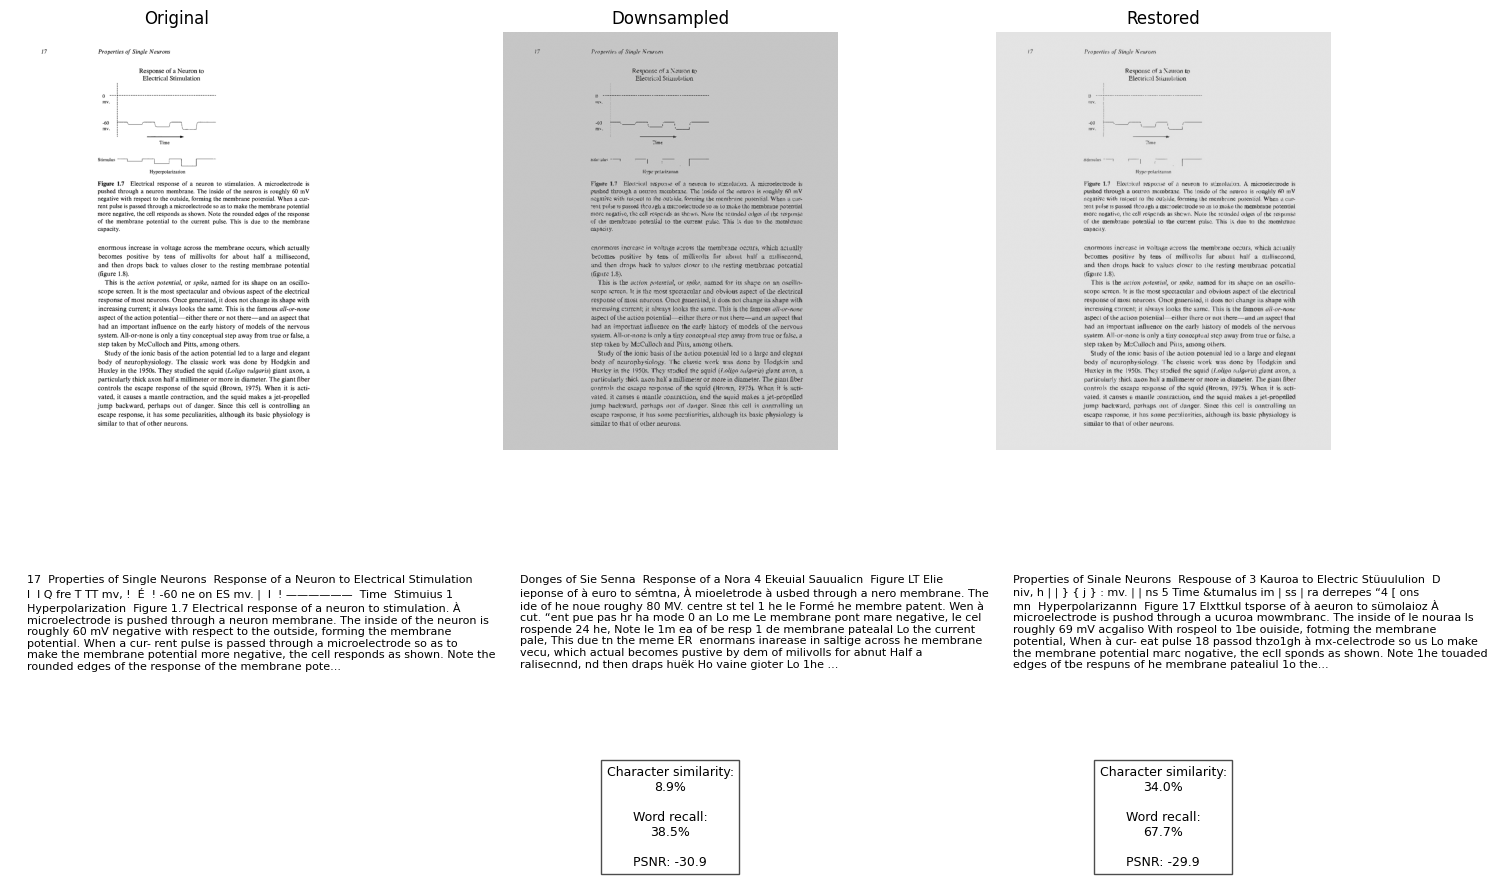

Restoration improvement:
Character similarity: +25.1%
Word recall: +29.2%
Finished testing document: test/test_pdfs/nn_textbook.pdf


In [41]:
for test_param in test_params.values():
    pdf_name = test_param['pdf_dir'].split("/")[-1]
    downsample_and_restore_image(test_param['pdf_dir'], test_param['page_num'], downsample_factors, model, device)
    
    original_text, downsampled_text, restored_text, downsampled_metrics, restored_metrics = visualize_comparison(
        original_path = img_dir + f"/{pdf_name}_Page_{test_param['page_num']}.png",
        downsampled_path= f"test/downsampled_images/downsampled_4x/{pdf_name}_Page_{test_param['page_num']}.png",
        restored_path = f"test/downsampled_images/restoration_4x/{pdf_name}_Page_{test_param['page_num']}.png",
        lang = test_param['pdf_language'],
        page_num=test_param['page_num'],
        chinese_font = test_param['is_chinese'],
        pdf_name = pdf_name,
        wrap_cut = test_param['wrap cut'],
        word_limit = test_param['word_limit']
    )
    print("Finished testing document:",test_param['pdf_dir'])

## Batch Test performance of flipped images
We selected a document that had good restoration outcomes as example.

In [ ]:
img_dir = f"test/test_images"
downampled_dir = f"test/downsampled_images/downsampled"
recovered_dir = "test/recovered_images"
downsampled_dir = "test/downsampled_images"

def downsample_and_restore_image_start_from_image(pdf_dir, page_num, downsample_factors, model, device):
    downsample_by_factors(img_dir, downampled_dir, downsample_factors)
    pdf_name = pdf_dir.split("/")[-1]
    restore_full_page(page_num, downsampled_dir, model, device, pdf_name)
    print(f"Finished downsampling and processing {pdf_dir} page {page_num}")

In [ ]:
flip_test_params = {
    "both_flip": {
        "page_num": 0,  # Change this to the page number you want to test on
        "pdf_dir": "test/test_images/both_flip_Project Rubric.pdf",  # Change this to the path of the PDF you want to use
        "original_pdf_dir": "test/test_pdfs/Project Rubric.pdf",
        "pdf_language": "eng",
        "is_chinese": False,  # Uncomment this to show Chinese characters in plots
        "wrap cut": 80,
        "word_limit": 600,
        "horiz_flip": True,
        "vert_flip": True
    },
    "horizontal_flip": {
        "page_num": 0,  # Change this to the page number you want to test on
        "pdf_dir": "test/test_images/horizontal_flip_Project Rubric.pdf",  # Change this to the path of the PDF you want to use
        "original_pdf_dir": "test/test_pdfs/Project Rubric.pdf",
        "pdf_language": "eng",
        "is_chinese": False,  # Uncomment this to show Chinese characters in plots
        "wrap cut": 80,
        "word_limit": 600,
        "horiz_flip": True,
        "vert_flip": False
    },
    "vertical_flip": {
        "page_num": 0,  # Change this to the page number you want to test on
        "pdf_dir": "test/test_images/vertical_flip_Project Rubric.pdf",  # Change this to the path of the PDF you want to use
        "original_pdf_dir": "test/test_pdfs/Project Rubric.pdf",
        "pdf_language": "eng",
        "is_chinese": False,  # Uncomment this to show Chinese characters in plots
        "wrap cut": 80,
        "word_limit": 600,
        "horiz_flip": False,
        "vert_flip": True
    },
}

Downsampling by factors complete!
Finished downsampling and processing test/test_images/both_flip_Project Rubric.pdf page 0
Applied flips and saved back to: test/downsampled_images/restoration_4x/both_flip_Project Rubric.pdf_Page_0.png


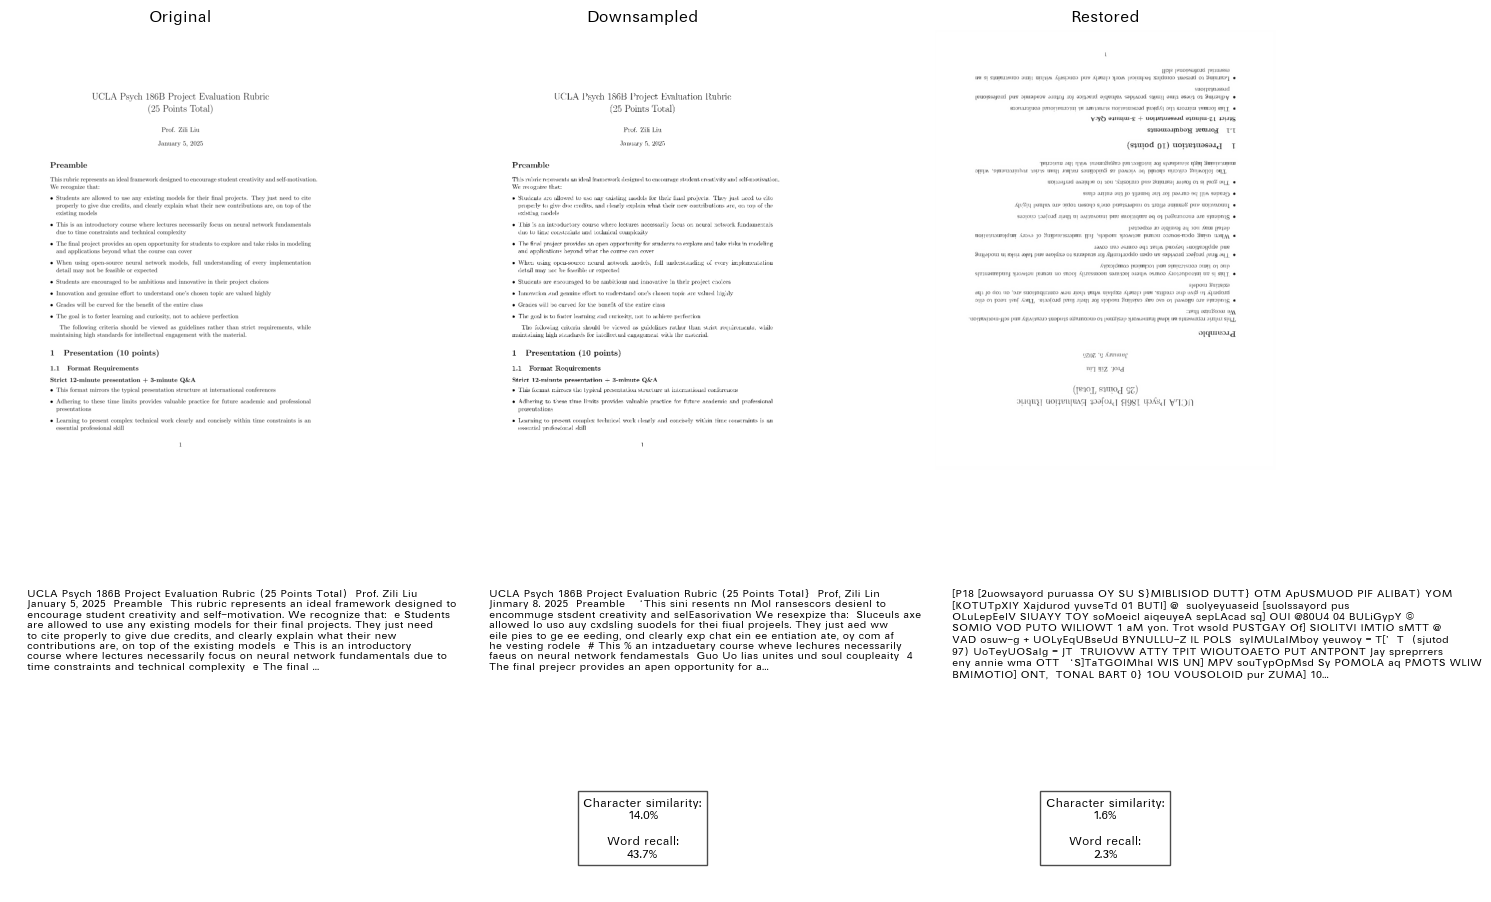

Restoration improvement:
Character similarity: +-12.5%
Word recall: +-41.4%
Finished testing document: test/test_images/both_flip_Project Rubric.pdf
Downsampling by factors complete!
Finished downsampling and processing test/test_images/horizontal_flip_Project Rubric.pdf page 0
Applied flips and saved back to: test/downsampled_images/restoration_4x/horizontal_flip_Project Rubric.pdf_Page_0.png


/var/folders/pc/06rgnz2s161dhwcz3q9v_96c0000gn/T/ipykernel_95665/1391648608.py:109: UserWarning: Glyph 171 (\N{LEFT-POINTING DOUBLE ANGLE QUOTATION MARK}) missing from font(s) Hei.
  plt.tight_layout()
/var/folders/pc/06rgnz2s161dhwcz3q9v_96c0000gn/T/ipykernel_95665/1391648608.py:109: UserWarning: Glyph 174 (\N{REGISTERED SIGN}) missing from font(s) Hei.
  plt.tight_layout()
/var/folders/pc/06rgnz2s161dhwcz3q9v_96c0000gn/T/ipykernel_95665/1391648608.py:111: UserWarning: Glyph 171 (\N{LEFT-POINTING DOUBLE ANGLE QUOTATION MARK}) missing from font(s) Hei.
  plt.savefig(f'test/comparison_results/comparison_results_{pdf_name}_{page_num}.png', dpi=2000)
/var/folders/pc/06rgnz2s161dhwcz3q9v_96c0000gn/T/ipykernel_95665/1391648608.py:111: UserWarning: Glyph 174 (\N{REGISTERED SIGN}) missing from font(s) Hei.
  plt.savefig(f'test/comparison_results/comparison_results_{pdf_name}_{page_num}.png', dpi=2000)
/Users/janysli/miniconda3/envs/text_super_resol/lib/python3.13/site-packages/IPython/core/py

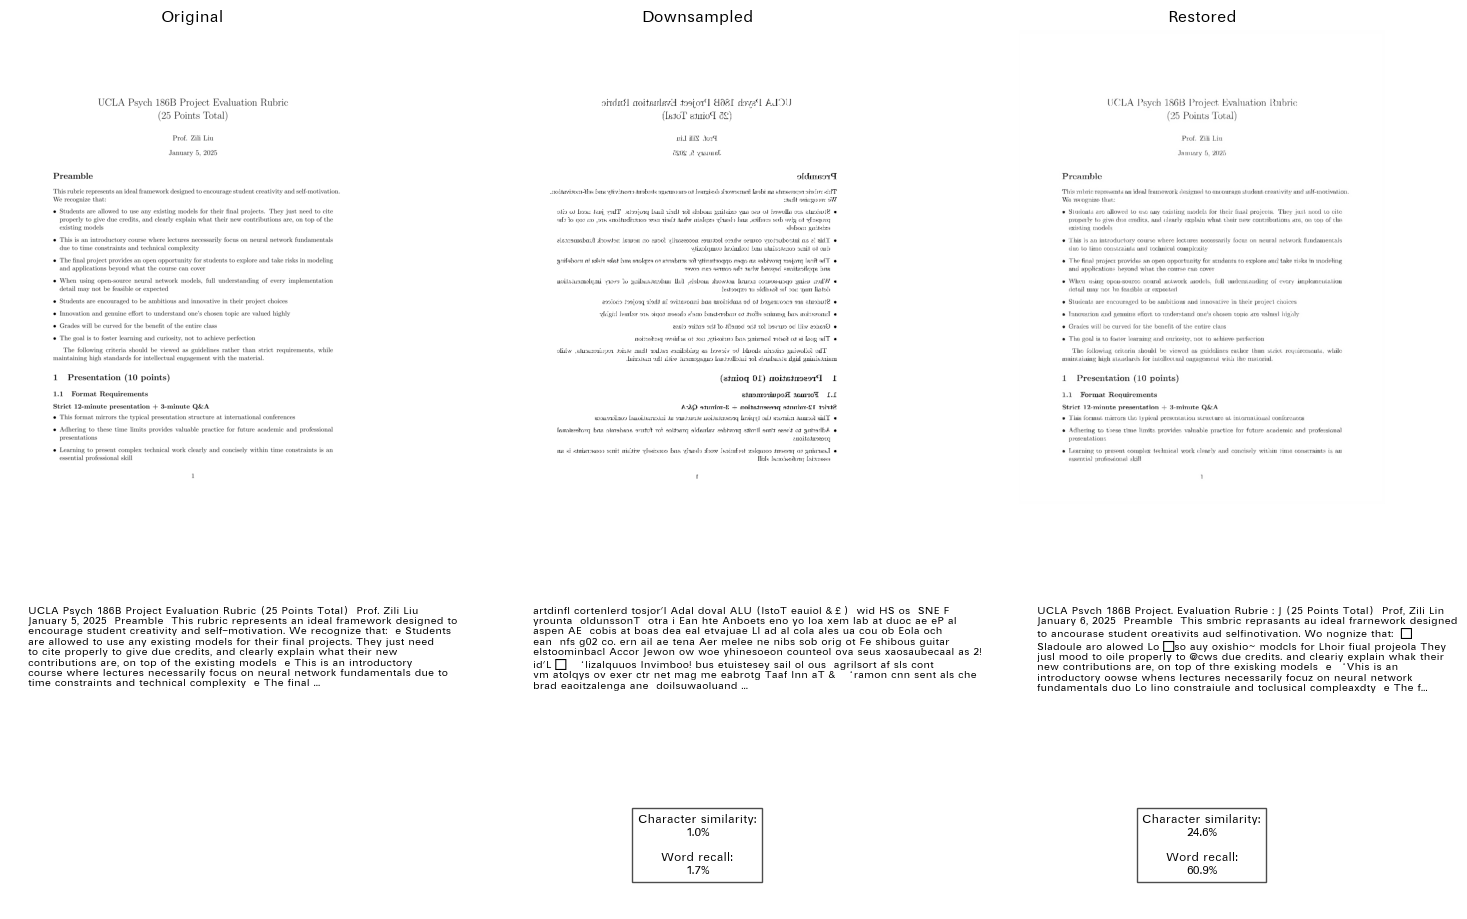

Restoration improvement:
Character similarity: +23.7%
Word recall: +59.2%
Finished testing document: test/test_images/horizontal_flip_Project Rubric.pdf
Downsampling by factors complete!
Finished downsampling and processing test/test_images/vertical_flip_Project Rubric.pdf page 0
Applied flips and saved back to: test/downsampled_images/restoration_4x/vertical_flip_Project Rubric.pdf_Page_0.png


/var/folders/pc/06rgnz2s161dhwcz3q9v_96c0000gn/T/ipykernel_95665/1391648608.py:109: UserWarning: Glyph 174 (\N{REGISTERED SIGN}) missing from font(s) Hei.
  plt.tight_layout()
/var/folders/pc/06rgnz2s161dhwcz3q9v_96c0000gn/T/ipykernel_95665/1391648608.py:111: UserWarning: Glyph 174 (\N{REGISTERED SIGN}) missing from font(s) Hei.
  plt.savefig(f'test/comparison_results/comparison_results_{pdf_name}_{page_num}.png', dpi=2000)
/Users/janysli/miniconda3/envs/text_super_resol/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 174 (\N{REGISTERED SIGN}) missing from font(s) Hei.
  fig.canvas.print_figure(bytes_io, **kw)


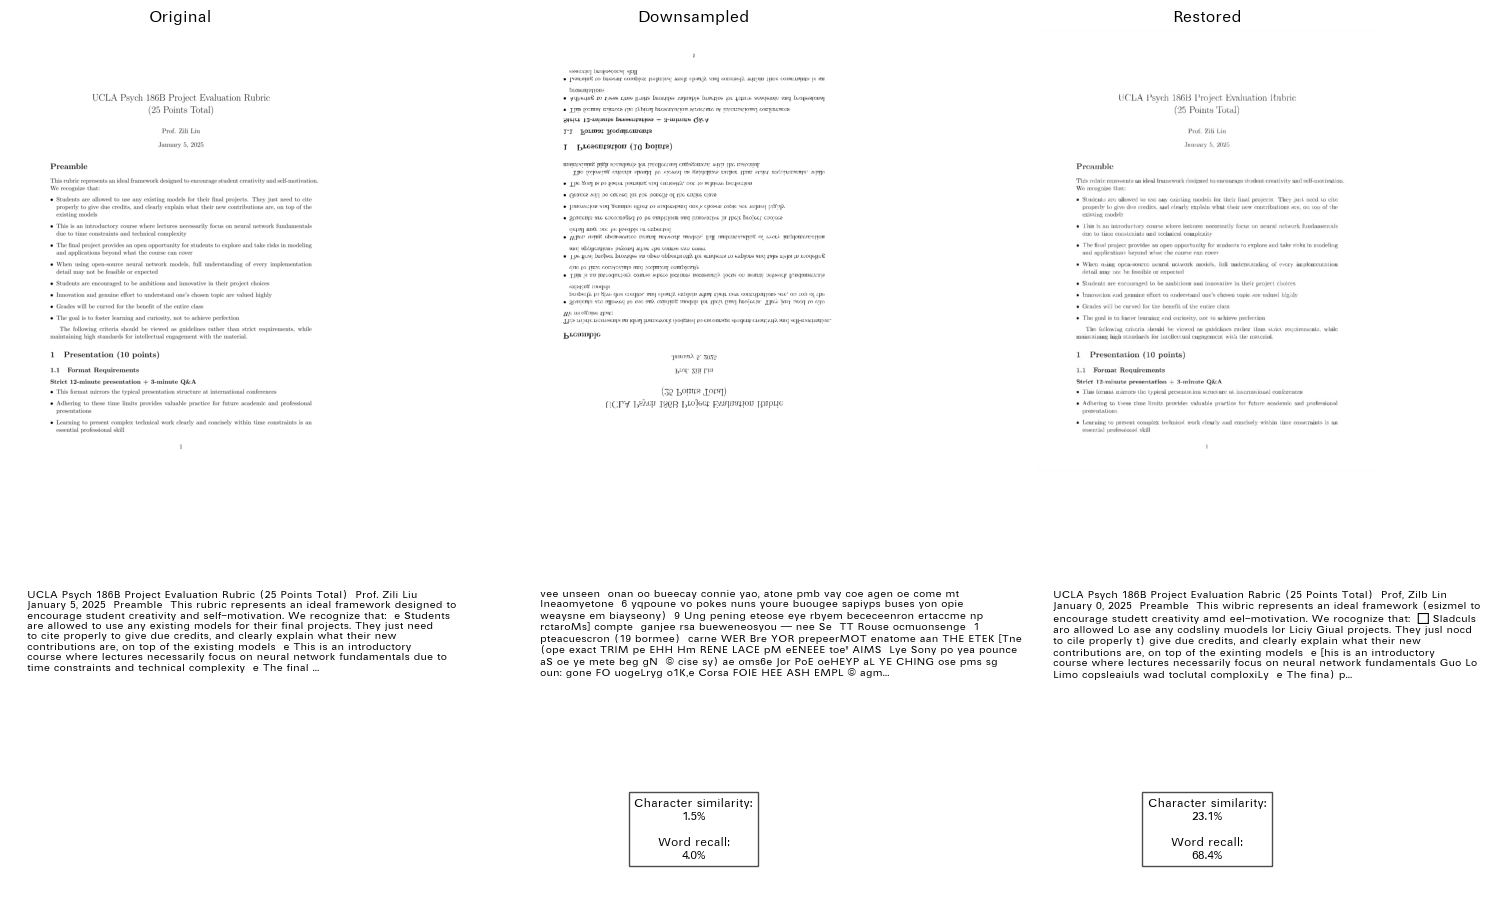

Restoration improvement:
Character similarity: +21.5%
Word recall: +64.4%
Finished testing document: test/test_images/vertical_flip_Project Rubric.pdf


In [ ]:
import os
from PIL import Image

for test_param in flip_test_params.values():
    pdf_name = test_param['pdf_dir'].split("/")[-1]
    original_pdf_name = test_param['original_pdf_dir'].split("/")[-1]
    
    # Step 1: Perform Downsampling & Restoration
    downsample_and_restore_image_start_from_image(test_param['pdf_dir'], test_param['page_num'], downsample_factors, model, device)

    # Define file paths
    restored_path = f"test/downsampled_images/restoration_4x/{pdf_name}_Page_{test_param['page_num']}.png"
    
    # Step 2: Perform Flipping if Required
    if test_param['horiz_flip'] or test_param['vert_flip']:
        # Open the restored image
        img = Image.open(restored_path)


        if test_param['horiz_flip']:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)  # Perform horizontal flip

        if test_param['vert_flip']:
            img = img.transpose(Image.FLIP_TOP_BOTTOM)  # Perform vertical flip

        # Save the flipped image back to the same location
        img.save(restored_path)
        print(f"Applied flips and saved back to: {restored_path}")

    # Step 3: Perform Text Extraction & Visualization
    original_text, downsampled_text, restored_text, downsampled_metrics, restored_metrics = visualize_comparison(
        original_path = img_dir + f"/{original_pdf_name}_Page_{test_param['page_num']}.png",
        downsampled_path = f"test/downsampled_images/downsampled_4x/{pdf_name}_Page_{test_param['page_num']}.png",
        restored_path = restored_path,  # Uses updated path (flipped if applicable)
        lang = test_param['pdf_language'],
        page_num = test_param['page_num'],
        chinese_font = test_param['is_chinese'],
        pdf_name = pdf_name,
        wrap_cut = test_param['wrap cut'],
        word_limit = test_param['word_limit']
    )

    print("Finished testing document:", test_param['pdf_dir'])
